# LSST Camera Footprint Filter Demo

This notebook contains an LSST camera foot print filter for LSST opsim based survey simulations (http://astro-lsst-01.astro.washington.edu:8080/) and the output of the JPL based solar system object survey simulator (https://github.com/dirac-institute/survey_simulator). 

Requries the LSST stack.


Since the installation paths for objectsInField for users differ, we will not include
the generation of pointings through objectsInFiled here.

If the user wants to ensure that the used pointings are correct, the user should do the following steps:

First, copy 

input.config.footprintValidation, oneline_v2.0.db and footprintFilterValidationOrbits.des

to your objectsInField directory from the demo directory of surveySimPP

The pointings are generated in the user's objectsInField directory as follows:

echo "Circle\n2.06" > ../data/instrument_circle1.dat

oif -f input.config.footprintValidation > footprintvalidation.ephemeris.txt

The pointring fields can be extracted by executing

awk '$2==402942' footprintvalidation.ephemeris.txt

In [2]:
from surveySimPP.modules import PPFootprintFilter as fp

In [4]:
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import numpy as np
import os

In [19]:
def getSqlData(database,rows_start,nrows):
    """Import dataset from local SQL database
    
    Parameters:
    -----------
    database   ... path to database
    rows_start ... number of row to start
    rows_max   ... number of rows to select
    
    Returns:
    --------
    observations ... pandas dataframe containing observations from JPL database
    """
    con = sql.connect(database)
    observations = pd.read_sql("""SELECT * FROM observations LIMIT """+str(rows_start)+','+str(nrows), con)
    return observations

In [6]:
def randobs(ronsky=3,ra=180,dec=45, n=100000):

    """Create random observations centered on RA, Dec with radius r.
    Random observations are generated correctly only for declinations < dec+r.
    
    Parameters:
    ------------
    ronksy ... on sky radius [deg]
    ra     ... Right Ascension of center [deg]
    dec    ... Declination of center
    
    Returns:
    --------
    raout ... Right Ascension of fake observations
    decout ... Declination of fake observations
    
    """
    # radius of the circle
    # center of the circle (x, y)
    # random angle
    
    rnd1=np.random.rand(n)
    rnd2=np.random.rand(n)
    
    alpha = 2 * np.pi * rnd1
    # random radius
    r = ronsky * np.sqrt(rnd2)
    # calculating coordinates
    raout = r * np.cos(alpha) + ra
    decout = r * np.sin(alpha) + dec
    
    return np.mod(raout+360,360),decout

## Import LSST Opsim database 
This database contains LSST pointings and environmental information such as seeing.


In [17]:
db_path="../data/oneline_v2.0.db"

Select the first ten exposures of the LSST survey for testing purposes.

In [47]:
LSSTdf=getSqlData(db_path,0,1)

In [48]:
LSSTdf

,observationId,fieldRA,fieldDec,observationStartMJD,flush_by_mjd,visitExposureTime,filter,rotSkyPos,numExposures,airmass,...,moonAz,sunAz,sunRA,sunDec,moonRA,moonDec,moonDistance,solarElong,moonPhase,cummTelAz
0,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,r,182.732823,2,1.167313,...,255.879834,249.525893,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656


## Create fake observation data

In [22]:
nobs_per_field=10000

In [23]:
rao,deco=randobs(ronsky=2.5,ra=LSSTdf['fieldRA'][0],dec=LSSTdf['fieldDec'][0],n=nobs_per_field)
dfobs0=pd.DataFrame(np.array([rao,deco]).T,columns=['AstRA(deg)','AstDec(deg)'])
dfobs0['FieldMJD']=LSSTdf['observationStartMJD'][0]

In [25]:
"""rao,deco=randobs(ronsky=2.5,ra=LSSTdf['fieldRA'][2],dec=LSSTdf['fieldDec'][2],n=nobs_per_field)
dfobs1=pd.DataFrame(np.array([rao,deco]).T,columns=['AstRA(deg)','AstDec(deg)'])
dfobs1['FieldMJD']=LSSTdf['observationStartMJD'][2]"""

"rao,deco=randobs(ronsky=2.5,ra=LSSTdf['fieldRA'][2],dec=LSSTdf['fieldDec'][2],n=nobs_per_field)\ndfobs1=pd.DataFrame(np.array([rao,deco]).T,columns=['AstRA(deg)','AstDec(deg)'])\ndfobs1['FieldMJD']=LSSTdf['observationStartMJD'][2]"

## Grab simulated observations

In [63]:
#dfobs=pd.concat([dfobs0,dfobs1])
#dfobs.reset_index(inplace=True,drop=True)
dfobs = pd.read_csv("footprintFilterValidationObservations.csv", delim_whitespace=True)

In [64]:
dfobs

,ObjID,FieldID,FieldMJD,AstRange(km),AstRangeRate(km/s),AstRA(deg),AstRARate(deg/day),AstDec(deg),AstDecRate(deg/day),Ast-Sun(J2000x)(km),...,Ast-Sun(J2000vz)(km/s),Obs-Sun(J2000x)(km),Obs-Sun(J2000y)(km),Obs-Sun(J2000z)(km),Obs-Sun(J2000vx)(km/s),Obs-Sun(J2000vy)(km/s),Obs-Sun(J2000vz)(km/s),Sun-Ast-Obs(deg),V,V(H=0)
0,S0000w6ca,402942.0,60945.035513,344266000.0,9.645862,273.950475,0.145419,-25.409570,-0.034414,171050400.0,...,5.477871,149626900.0,9189664.0,3981839.0,-2.165552,27.419133,11.778333,23.579048,28.916485,4.915485
1,S0000wkZa,402942.0,60945.035513,93728970.0,24.810874,273.029493,1.592210,-24.398177,-0.243588,154138100.0,...,-2.670822,149626900.0,9189664.0,3981839.0,-2.165552,27.419133,11.778333,58.765271,25.451943,1.441943
2,S0000wspa,402942.0,60945.035513,330569600.0,21.915557,274.480023,0.072605,-25.283050,0.093505,172974700.0,...,8.064873,149626900.0,9189664.0,3981839.0,-2.165552,27.419133,11.778333,24.363095,28.799210,4.784210
3,S0000wUea,402942.0,60945.035513,492613400.0,25.078801,273.646543,0.109090,-25.456436,0.005462,177915900.0,...,1.489699,149626900.0,9189664.0,3981839.0,-2.165552,27.419133,11.778333,16.976109,30.199404,6.167404
4,S0000xl3a,402942.0,60945.035513,200278800.0,30.796080,271.853254,0.734379,-23.453650,-0.003425,155568800.0,...,-0.605902,149626900.0,9189664.0,3981839.0,-2.165552,27.419133,11.778333,37.584025,27.273330,3.225330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29051,mpc00K8271,402942.0,60945.035513,360725700.0,20.617454,272.594036,0.244908,-25.480627,0.015066,164365000.0,...,3.899935,149626900.0,9189664.0,3981839.0,-2.165552,27.419133,11.778333,22.787741,22.312084,5.062084
29052,mpc00K9056,402942.0,60945.035513,261587100.0,16.465273,272.172454,0.412457,-25.517282,0.032230,158575700.0,...,6.222693,149626900.0,9189664.0,3981839.0,-2.165552,27.419133,11.778333,30.279516,21.032581,4.012581
29053,mpc00K9551,402942.0,60945.035513,298658200.0,16.740250,274.477149,0.288844,-26.376947,0.009252,170513400.0,...,4.841374,149626900.0,9189664.0,3981839.0,-2.165552,27.419133,11.778333,26.624500,21.221274,4.451274
29054,mpc00K9617,402942.0,60945.035513,371087000.0,21.670828,272.019401,0.241333,-24.188684,0.022293,161555100.0,...,4.423580,149626900.0,9189664.0,3981839.0,-2.165552,27.419133,11.778333,22.274549,22.124108,5.154108


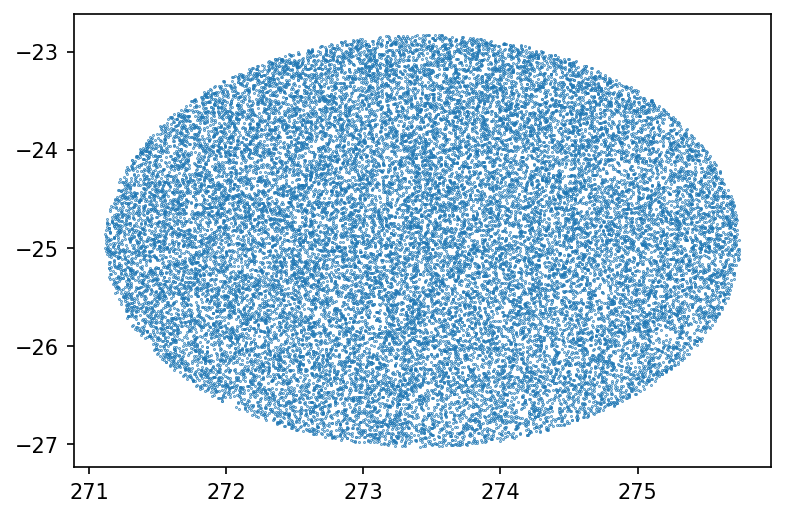

In [65]:
plt.figure(dpi=150,figsize=(6,4))
plt.scatter(dfobs['AstRA(deg)'],dfobs['AstDec(deg)'],s=0.1)
plt.show()

## Select pointings from LSST opsim 

In [55]:
dfpointings=LSSTdf

In [56]:
dfpointings

,observationId,fieldRA,fieldDec,observationStartMJD,flush_by_mjd,visitExposureTime,filter,rotSkyPos,numExposures,airmass,...,moonAz,sunAz,sunRA,sunDec,moonRA,moonDec,moonDistance,solarElong,moonPhase,cummTelAz
0,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,r,182.732823,2,1.167313,...,255.879834,249.525893,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656


In [66]:
dfobs = pd.merge(dfobs, LSSTdf, left_on="FieldID", right_on="observationId", how="left")

## Test Filtering on fake observations.

In [57]:
camera = fp.Footprint("../data/detectors_corners.csv")

CPU times: user 52.9 ms, sys: 0 ns, total: 52.9 ms
Wall time: 81.6 ms


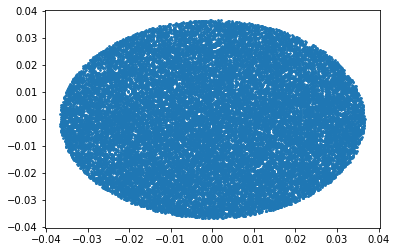

In [67]:
%%time
df_new=camera.applyFootprint(dfobs)

In [72]:
dfobs_in_fp = dfobs.iloc[df_new[0]]

In [77]:
dfobs_in_fp

,ObjID,FieldID,FieldMJD,AstRange(km),AstRangeRate(km/s),AstRA(deg),AstRARate(deg/day),AstDec(deg),AstDecRate(deg/day),Ast-Sun(J2000x)(km),...,moonAz,sunAz,sunRA,sunDec,moonRA,moonDec,moonDistance,solarElong,moonPhase,cummTelAz
184,S0000qEoa,402942.0,60945.035513,387445900.0,24.937591,274.368502,0.140563,-23.230652,0.005002,176746300.0,...,255.879834,249.525893,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656
374,S1001Q51a,402942.0,60945.035513,406746600.0,23.471586,274.255988,0.214356,-23.310009,-0.004073,177348800.0,...,255.879834,249.525893,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656
448,S1006IoOa,402942.0,60945.035513,317372700.0,19.818773,274.444716,0.272782,-23.345640,-0.018433,172208800.0,...,255.879834,249.525893,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656
538,S1000Ks7a,402942.0,60945.035513,346006200.0,23.300574,274.429778,0.254463,-23.156810,0.014485,174198300.0,...,255.879834,249.525893,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656
773,S1006rEca,402942.0,60945.035513,393096900.0,20.805666,274.283327,0.201285,-23.226368,0.016283,176607200.0,...,255.879834,249.525893,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27426,mpcK17B32N,402942.0,60945.035513,110491500.0,5.913646,272.495186,0.581329,-26.689091,-0.086678,153924700.0,...,255.879834,249.525893,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656
27821,mpcK12DA8D,402942.0,60945.035513,347987400.0,24.193037,272.577922,0.304269,-26.678877,0.043013,163612400.0,...,255.879834,249.525893,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656
28384,mpcK16A35J,402942.0,60945.035513,384200300.0,22.344931,272.483062,0.224164,-26.507794,-0.027891,164522200.0,...,255.879834,249.525893,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656
28808,mpcK14Wr0K,402942.0,60945.035513,410177600.0,24.292635,272.582601,0.217256,-26.649959,0.054629,166145800.0,...,255.879834,249.525893,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656


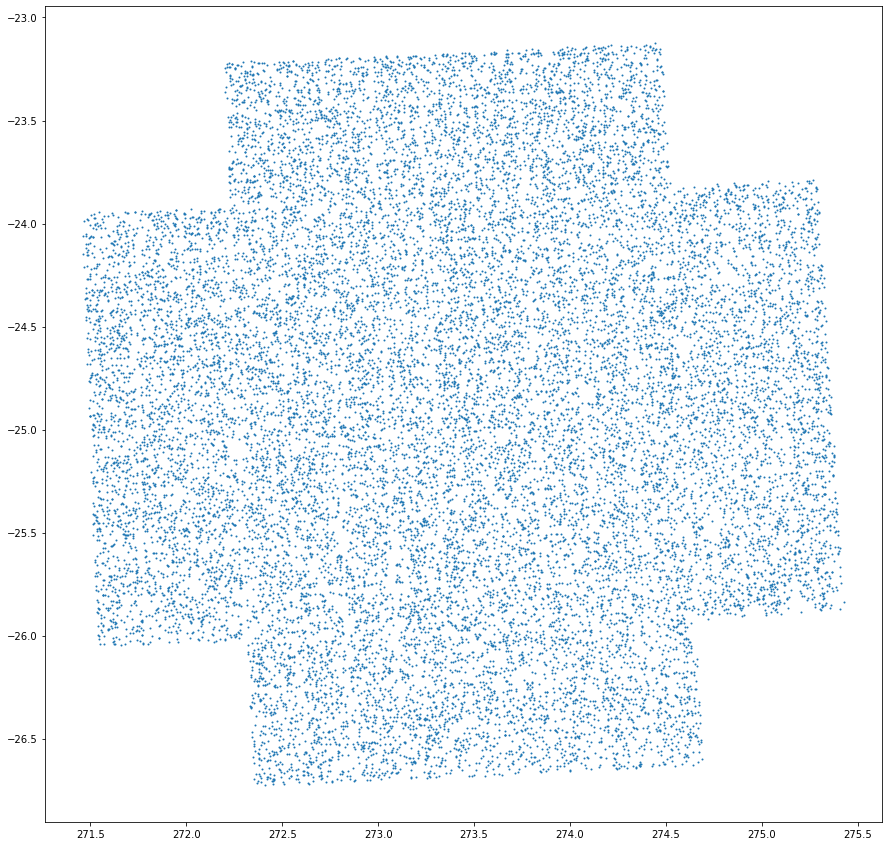

In [84]:
plt.figure(figsize=(15, 15))
plt.scatter(dfobs_in_fp['AstRA(deg)'],dfobs_in_fp['AstDec(deg)'],s=1.)
plt.show()

In [73]:
fp.plotFootprintFiltering(dfobs, df_new)

AttributeError: module 'surveySimPP.modules.PPFootprintFilter' has no attribute 'plotFootprintFiltering'

In [ ]:
#df_new.to_csv('test_output_PPFootprintFilter.csv', index=False)

In [ ]:
#dfobs.to_csv('test_input_PPFootprintFilter.csv', index=False)

In [34]:
out = os.system("oif -f ../../oif-hyak/test/input.config")

START HEADER
[CONF]
n_Proc		    = 1
[ASTEROID]
Population model    = asteroids.s3m
SPK T0              = 59200
nDays               = 800
SPK step            = 30
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = sample-lsst_baseline_v1p4_test.db
Field1              = 1
nFields             = 1000
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM SummaryAllProps order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = csv
[CAMERA]
Camera              = instrument_polygon.dat
Threshold           = 5
Survey length:
Field 1 : 59853.98564382085
Field n : 59855.015756339824
Days : 2.0
END HEADER
ObjID,FieldID,FieldMJD,AstRange(km),AstRangeRate(km/s),AstRA(deg),AstRARate(deg/day),AstDec(deg),AstDecRate(deg/day),Ast-Sun(J2000x)(km),Ast-Sun(J2000y)(km),Ast-Sun(J2000z)(km),Ast-Sun(J2000vx)(km/s),Ast-Sun(J2000vy)(km/s),Ast-Sun(J2000vz)(km/s),Obs-Sun(J2000x)(

In [35]:
out

0

In [46]:
ctr=0
a=1.0
while (a<3.5):
   e=0.0
   while(e<1.0):
      incl=0.0
      while(incl<180.):
          argperi=0.0
          while(argperi<360.):
              longnode=0.0
              while(longnode<360.):
                  manomaly=0.0
                  while(manomaly<360.):
                      ctr=ctr=ctr+1
                      current_orbit=[a,e,incl,argperi,longnode,manomaly]
                      str_current_orbit=(str(ctr) + ' KEP ' + str(a) + ' ' + str(e) + ' ' + str(incl) + ' ' + str(argperi) + ' ' + str(longnode) + ' ' + str(manomaly) + ' 16.0 54466.0 1 6 -1 PPROC')
                      with open('tmp.des','w') as f:
                           f.write('!!OID FORMAT a e i node argperi M H t_0 INDEX N_PAR MOID COMPCODE\n')
                           f.write(str_current_orbit)
                      f.close()
                      os.system("oif -f ../../oif-hyak/test/input.config.tmp")
                      # Oif current_orbit
                      # Store image, count number of values
                      # Run through footprint filter only
                      # Store image, count  number of values
                      manomaly=manomaly+359.
                  longnode=longnode+359.
              argperi=argperi+359.
          incl=incl+179.
      e=e+0.99
   a=a+2.4

START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'
Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such f

START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5
START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FR

Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'
Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such f

START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5
START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FR

Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'
Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such f

START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5
START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FR

Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'
Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such f

START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5
START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FR

Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'
Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such f

START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5
START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FR

Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'
Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such f

START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5
START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FR

Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'
Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such f

START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5
START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FR

Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'
Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such f

START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5
START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FR

Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 264, in main
    a.generatestates(nbody,spkstart-10, spkstart+spkndays+100,spkstep, args.f)
  File "/home/sam/git-workspaces/oif-hyak/oif/sso.py", line 702, in generatestates
    i.save(self.outputfile, force)
  File "/home/sam/git-workspaces/oif-hyak/oif/sso.py", line 342, in save
    spicestateseq[counter]=sp.mxvg(matrix,spicestates[counter],6,6)
  File "/home/sam/miniconda3/envs/oif-dev/lib/python3.9/site-packages/spiceypy/spiceypy.py", line 123, in with_errcheck
    res = f(*args, **kwargs)
  File "/home/sam/miniconda3/envs/oif-dev/lib/python3.9/site-packages/spiceypy/spiceypy.py", line 9053, in mxvg
    return stypes.c_vector_to_python(vout)
  File "/home/sam/miniconda3/envs/oif-dev/lib/python3.9/site-packages/spiceypy/utils/support_types.py", li

START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'
Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such f

START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "<frozen importlib._bootstrap_external>", line 1353, in _path_importer_cache
KeyError: '/home/sam/miniconda3/envs/oif-dev/lib/python3.9/html'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 25, in importlib_load_entry_point
    return next(matches).load()
  File "/home/sam/miniconda3/envs/oif-dev/lib/python3.9/importlib/metadata.py", line 77, in load
    module = import_module(match.group('module'))
  File "/home/sam/miniconda3/envs/oif-dev/lib/python3.9/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1030, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_l

START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5
START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FR

Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'


START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5


Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'
Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such f

START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5
START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FR

Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'
Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such f

START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FROM observations order by observationStartMJD
[OUTPUT]
Output file          = stdout
Output format        = whitespace
[CAMERA]
Camera              = instrument_circle1.dat
Threshold           = 5
START HEADER
[ASTEROID]
Population model    = tmp.des
SPK T0              = 59200
nDays               = 8600
SPK step            = 1
nbody               = T
Input format       = whitespace
[SURVEY]
Survey database     = oneline_v2.0.db
Field1              = 1
nFields             = 1
Telescope           = I11
Surveydbquery       = SELECT observationId,observationStartMJD,fieldRA,fieldDEC,rotSkyPos FR

Traceback (most recent call last):
  File "/home/sam/miniconda3/envs/oif-dev/bin/oif", line 33, in <module>
    sys.exit(load_entry_point('oif', 'console_scripts', 'oif')())
  File "/home/sam/git-workspaces/oif-hyak/oif/__main__.py", line 269, in main
    c=ts.camera(cameradef_file,spiceik)
  File "/home/sam/git-workspaces/oif-hyak/oif/telescope.py", line 161, in __init__
    with open(configfile, newline='') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/home/sam/git-workspaces/oif-hyak/oif/data/instrument_circle1.dat'
